# Generative Adversarial Networks

### Cristiano De Nobili - My Contacts
For any questions or doubts you can find my contacts here:

<p align="center">

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Instagram_logo_2016.svg/2048px-Instagram_logo_2016.svg.png" width="20">](https://www.instagram.com/denocris/?hl=it)
[<img src="https://1.bp.blogspot.com/-Rwqcet_SHbk/T8_acMUmlmI/AAAAAAAAGgw/KD_fx__8Q4w/s1600/Twitter+bird.png" width="30">](https://twitter.com/denocris) 
[<img src="https://loghi-famosi.com/wp-content/uploads/2020/04/Linkedin-Simbolo.png" width="40">](https://www.linkedin.com/in/cristiano-de-nobili/)     

</p>

or here (https://denocris.com).

### Useful Links

All notebooks can be found [here!](https://drive.google.com/drive/folders/1i3cNfzWZTNXfvkFVVIIDXjRDdSa9L9Dv?usp=sharing)

Introductory slides [here!](https://www.canva.com/design/DAEa5hLfuWg/-L2EFFfZLVuiDkmg4KiKkQ/view?utm_content=DAEa5hLfuWg&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink)

Collection of references: [here!](https://denocris.notion.site/Deep-Learning-References-0c5af2dc5c8d40baba19f1328d596fff)


### Useful Refs

* Original Paper: [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661);
* [Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN);
* [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160);
* [MIT GAN Lecture](https://www.youtube.com/watch?v=yFBFl1cLYx8&index=1&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI).
* [Why do GANs need so much noise? (TDS blog post)](https://towardsdatascience.com/why-do-gans-need-so-much-noise-1eae6c0fb177)


## What are GANs?


Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to distinguish real images apart from fakes.

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.


This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.


![gan_intro_scheme](https://drive.google.com/uc?id=1rSRdg-ENTsCmgkYuKf3hMvoc4xstA8Wh)

Schematically, a GAN looks like

* a generator network maps vectors of shape (latent_dim) to images (of shape (28, 28, 1) in our case);

* a discriminator network maps images of shape (28, 28, 1) to a binary score estimating the probability that the image is real;

* a gan network chains the generator and the discriminator together. Thus this gan network maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as decoded by the generator.

* we train the discriminator using examples of real and fake images along with 1/0 labels, as we would train any regular image classification model.

* to train the generator, we use the gradients of the generator’s weights with regard to the loss of the gan model. This means that, at every step, we move the weights of the generator in a direction that will make the discriminator more likely to classify as “real” the images decoded by the generator. I.e. we train the generator to fool the discriminator.



The latent space itself has no meaning. Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one. Through training, the generator learns to map points into the latent space with specific output images and this mapping will be different each time the model is trained.

The latent space has structure when interpreted by the generator model, and this structure can be queried and navigated for a given model.

## Importing Libraries

In [ ]:
%%capture
# To generate GIFs
!pip install imageio

In [ ]:
import math as m
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as vutils
from torchsummary import summary


from IPython import display

## Import MNIST Data

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [ ]:
# set the seed for reproducibility: built-in python, numpy, and pytorch
seed = 172
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # works for all devices (CPU and GPU)

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
%%capture 
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize( (0.5,), (0.5,) )])
# for 3-channel images: transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

# Download 
# DataLoader: combines a dataset and a sampler, and provides an iterable over the given dataset.
dataloader = DataLoader(MNIST(root = './data', train = True, transform = transform, download=True), batch_size=batch_size , shuffle=False)


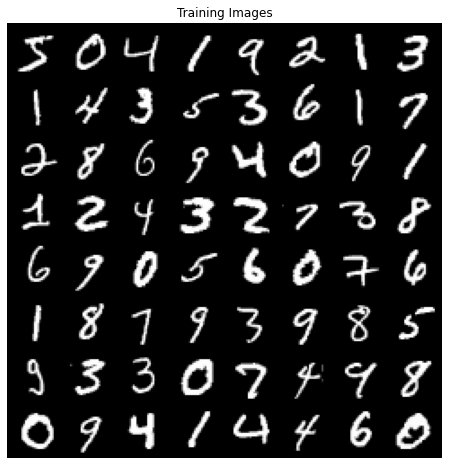

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2, normalize=True),(1,2,0)))

## Create the models


The discriminator's training data comes from two sources:

* **Real data instances**, such as real pictures of people. The discriminator uses these instances as positive examples during training.

* **Fake data instances** created by the generator. The discriminator uses these instances as negative examples during training.




### The Generator

The generator uses `nn.ConvTranspose2d` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `nn.LeakyReLU` activation for each layer, except the output layer which uses tanh.

Transposed convolution are used instead of un-pooloing since they are learnable. Their parameters can be learned by the generator as we will see.

https://towardsdatascience.com/demystifying-gans-in-tensorflow-2-0-9890834ab3d9

![gan_generator](https://drive.google.com/uc?id=1UeBidGWXuvlNzIPd__lFIK3fsAcOYqbU)

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64


In [ ]:
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
      super(Generator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(in_channels = nz, out_channels = ngf*4, kernel_size= 4, stride = 1, padding = 0, bias=False), 
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )
  
    def forward(self, input):
      output = self.network(input)
      return output #.view(-1,1).squeeze()

In [ ]:
generator_model = Generator(nc = 1, nz = 100, ngf = 64) 
generator_model.to(device)

summary(generator_model, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 7, 7]         294,912
       BatchNorm2d-5            [-1, 128, 7, 7]             256
              ReLU-6            [-1, 128, 7, 7]               0
   ConvTranspose2d-7           [-1, 64, 14, 14]         131,072
       BatchNorm2d-8           [-1, 64, 14, 14]             128
              ReLU-9           [-1, 64, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,024
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 837,504
Trainable params: 837,504
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
# Generator Code

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
                
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
discriminator_model = Discriminator(nc = 1, ndf = 64)
discriminator_model.to(device)

summary(discriminator_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,024
         LeakyReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,072
       BatchNorm2d-4            [-1, 128, 7, 7]             256
         LeakyReLU-5            [-1, 128, 7, 7]               0
            Conv2d-6            [-1, 256, 4, 4]         294,912
       BatchNorm2d-7            [-1, 256, 4, 4]             512
         LeakyReLU-8            [-1, 256, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           4,096
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 431,872
Trainable params: 431,872
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.65
Estimated T

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

## Define the loss and optimizers


The GAN framework pits two adversaries against each other in a game.
Each player is represented by a differentiable function controlled by a set of parameters. Typically these functions are implemented as deep neural networks. The game plays out in two scenarios. 

In one scenario, training examples x are randomly sampled from the training set and used as input for the first player, the discriminator, represented by the function D. 

The goal of the discriminator is to output the probability that its input is real (1) rather than fake (0), under the assumption that half of the inputs it is ever shown are real and half are fake. In this first scenario, the goal of the discriminator is for D(x) to be near 1. 

In the second scenario, inputs z to the generator are randomly
sampled from the model’s prior over the latent variables. The discriminator then
receives input G(z), a fake sample created by the generator. In this scenario, both players participate. The discriminator strives to make D(G(z)) approach 0 while the generative strives to make the same quantity approach 1. If both models have sufficient capacity, then the Nash equilibrium of this game corresponds to the G(z) being drawn from the same distribution as the training data, and D(x) = 1/2 for all x.


GANs are end-to-end differentiable, which means we have the luxury of training them with backpropagation+gradient descent

Binary cross entropy is defined as

$$L(y, \hat y) = -\frac{1}{N} \sum_{i=0}^N [y \, \log(\hat y) +  (1-y)\, \log(1- \hat y)]$$

Binary crossentropy measures how far away from the true value (which is either 0 or 1) the prediction is for each of the classes and then averages these class-wise errors to obtain the final loss.

### Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

Considering the above formula of binary cross entropy

$$\text{real_loss} = L(1, \text{real_output})= - \frac{1}{N} \sum_{i=0}^N \log (\text{real_output}), \quad \text{real_output} = D(x_i) $$

$$\text{fake_loss} = L(0, \text{fake_output})= - \frac{1}{N} \sum_{i=0}^N \log (1 -\text{fake_output}), \quad \text{fake_output} = D(G(z_i))$$

Therefore the total cost function of the discriminator can be written
$$L_{D} = - (\mathbb{E} [\log D(x)] + \mathbb{E} [\log (1 - D(G(z)))])$$


The discriminator loss penalizes the discriminator for misclassifying a real instance as fake or a fake instance as real.

```python
# Calculate loss on all-real batch
D_loss_real = criterion(real_output, real_label) # log(D(x)) 
D_loss_real.backward()

# Calculate loss on all-fake batch
D_loss_fake = criterion(fake_output, fake_label) # log(1 - D(G(z)))
D_loss_fake.backward()

# Sum over the fake and the real batches
D_loss = D_loss_real + D_loss_fake
```

### Generator loss


The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s. In other words, we want to train the Generator by minimizing $\mathbb{E} [\log (1 - D(G(z)))]$ in an effort to generate better fakes. However, this was shown to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize $\mathbb{E} [\log D(G(z))]$, or minimize $- \mathbb{E} [\log  D(G(z))]$

```python
# Calculate G's loss based on this output
# fake labels are real for generator cost
G_loss = criterion(fake_output, real_label)
# Calculate gradients for G
G_loss.backward()
```

### Model Instances

In [ ]:
generator_model = Generator(nc = 1, nz = 100, ngf = 64) 
generator_model.apply(weights_init)

generator_model.to(device)

discriminator_model = Discriminator(nc = 1, ndf = 64)
discriminator_model.apply(weights_init)

discriminator_model.to(device)



# Initialize BCELoss function
criterion = nn.BCELoss()

real_label = torch.full((batch_size,), 1. , dtype=torch.float, device=device)
fake_label = torch.full((batch_size,), 0. , dtype=torch.float, device=device)



# Learning rate for optimizers (value suggested in original DCGAN paper)
lr = 0.0002

# Beta1 hyperparam for Adam optimizers (value suggested in original DCGAN paper)
beta1 = 0.5

# Batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


### Optimizers

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
# Setup Adam optimizers for both G and D
D_optimizer = optim.Adam(discriminator_model.parameters(), lr=lr, betas=(beta1, 0.999))
G_optimizer = optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))

## Training 

The training loop goes as follow

* the generator receives a random seed as input. That seed is used to produce an image. 

* the discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator)

* the loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Training Loop
num_epochs = 5
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):


        real_images = data[0].to(device)
        b_size = real_images.size(0)
                
        real_label = torch.full((b_size,), 1. , dtype=torch.float, device=device)
        fake_label = torch.full((b_size,), 0. , dtype=torch.float, device=device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        ## Train with all-real batch
        discriminator_model.zero_grad()

        # Forward pass real batch through D
        real_output = discriminator_model(real_images).view(-1)
        D_x = real_output.mean().item()


        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake_images = generator_model(noise)
        #label.fill_(0.0)
        # Classify all fake batch with D
        fake_output = discriminator_model(fake_images.detach()).view(-1)
        D_G_z1 = fake_output.mean().item()


        #errD = discriminator_loss(real_output, fake_output)
        #errD.backward()
        #D_optimizer.step()

        # Calculate loss on all-real batch
        D_loss_real = criterion(real_output, real_label) # log(D(x)) 
        D_loss_real.backward()
        # Calculate loss on all-fake batch
        D_loss_fake = criterion(fake_output, fake_label) # log(1 - D(G(z)))
        D_loss_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        D_loss = D_loss_real + D_loss_fake
        # Calculate gradients for D in backward pass
        
        D_optimizer.step()
              

        # ================================================================== #
        #                      Train the generator                           #
        # ================================================================== #
        generator_model.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_output = discriminator_model(fake_images).view(-1)
        D_G_z2 = fake_output.mean().item()

        # Calculate G's loss based on this output
        # fake labels are real for generator cost
        G_loss = criterion(fake_output, real_label)
        # Calculate gradients for G (we are here just updating G weights and not D ones)
        G_loss.backward()
        # Update G
        G_optimizer.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_images = generator_model(fixed_noise).detach().cpu()
                print(fake_images.size())
            img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))

        iters += 1


## Plots

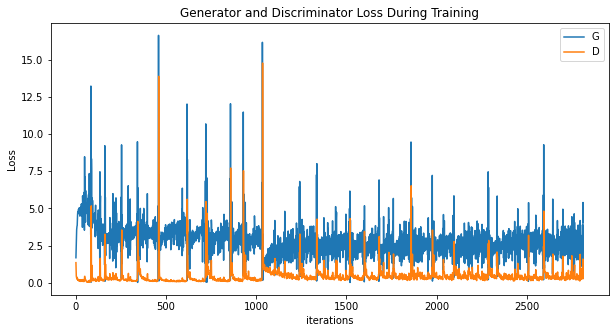

In [ ]:
# Loss functions

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

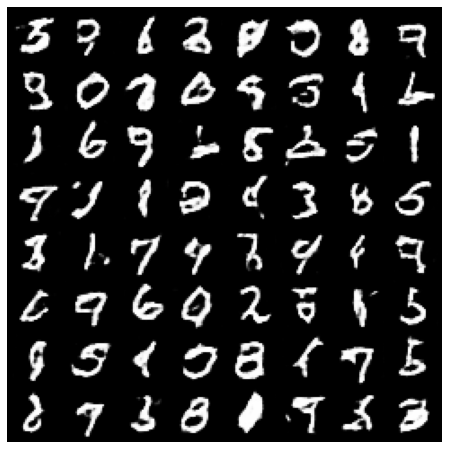

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())